# Minnesota potential

This notebook is dedicated to the Minnesota (MN) potential. It is meant to give the reader an idea how to use our software framework. It also creates the figures in the manuscript associated with this potential and more.

Let's import the Python modules:

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt

from Potential import Potential
from Channel import Channel
from ScatteringExp import ScatteringExp
from Grid import Grid

from scipy.special import factorial2, spherical_jn
from plots.rc_params import *
from string import ascii_lowercase as alphabet

## Visualization of the potential (Figure 5)

Next, we set up the training and validation sets in the potential's two-dimensional parameter space:

In [2]:
from constants import hbarc, cm
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
potential = Potential(channel, **potentialArgs)
Vs_range =  (-200, 0) # (-400, 0)  #
VR_range = (100, 300) # (0, 400) # 
Vs_center = np.mean(Vs_range)
VR_center = np.mean(VR_range)
seed = 124294784
np.random.seed(seed)
param_samples = {
    "training": potential.getLecsSample({"V0": VR_range, "V1": Vs_range}, n=25, seed=seed),
    "validation": potential.getLecsSample({"V0": VR_range, "V1": Vs_range}, n=1250, seed=seed)
}

Let's now plot the Minnesota potential's (affine) parameter space and the associated potentials:

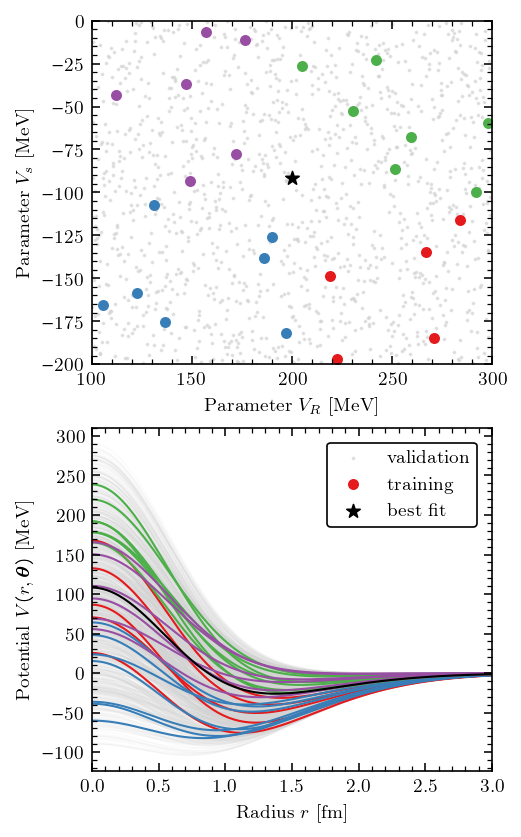

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
for index, lbl in enumerate(("validation", "training")):
    # randomly sample the 2d parameter space
    # we use 1250 random samples for validation and 25 for training
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    size_marker = [1, 20][index]
    size_line = [0.6, 1.0][index]
    alpha_lines = (0.1, 1.)[index]
        
    # left panel: parameter space
    masks = []
    masks.append(np.logical_and(param_samples_plot[:, 0] > VR_center, param_samples_plot[:, 1] < Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] < VR_center, param_samples_plot[:, 1] < Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] > VR_center, param_samples_plot[:, 1] > Vs_center))
    masks.append(np.logical_and(param_samples_plot[:, 0] < VR_center, param_samples_plot[:, 1] > Vs_center))
    
    if index == 1:
        alpha = 1 
        label = "training"
    else:
        alpha = 0.6
        label = "validation"

    for i_quadrant in range(4):
        color = colors[i_quadrant] if index == 1 else "lightgray"
        axs[0].scatter(param_samples_plot[masks[i_quadrant],0], param_samples_plot[masks[i_quadrant],1], 
                       alpha=alpha, color=color, s=size_marker, label=label if i_quadrant == 0 else "")

    # right panel: potential V(r)
    grid_plot = np.linspace(0, 4, 200)
    for i_quadrant in range(4): 
        mask = masks[i_quadrant]
        color = colors[i_quadrant] if index == 1 else "lightgray"
        add_lbl_to_legend = True if i_quadrant == 1 else False
        for ilec, lec_sample in enumerate(param_samples_all):
            if not mask[ilec]: 
                continue 
            if add_lbl_to_legend:
                label = ("validation", "training")[index]  
                add_lbl_to_legend = False
            else: 
                label = ""
            vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
            axs[1].plot(grid_plot, vr, color=color, lw=size_line, alpha=alpha_lines, label=label)
        
# plot best_fit value
axs[0].scatter(potential.lecBaseValues["V0"], potential.lecBaseValues["V1"], 
               color="k", s=45, marker="*", label="best fit")
vr = hbarc * potential.eval(r=grid_plot, lecs=potential.lecBaseValues)
axs[1].plot(grid_plot, vr, color="k", lw=size_line, alpha=alpha_lines, label="MN potential")

# axis labels and more
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(*VR_range)
axs[0].set_ylim(*Vs_range)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space_quadrants.png", dpi=200)

Alternatively (not shown in the manuscript), here's a version without coloring the four quadrants:

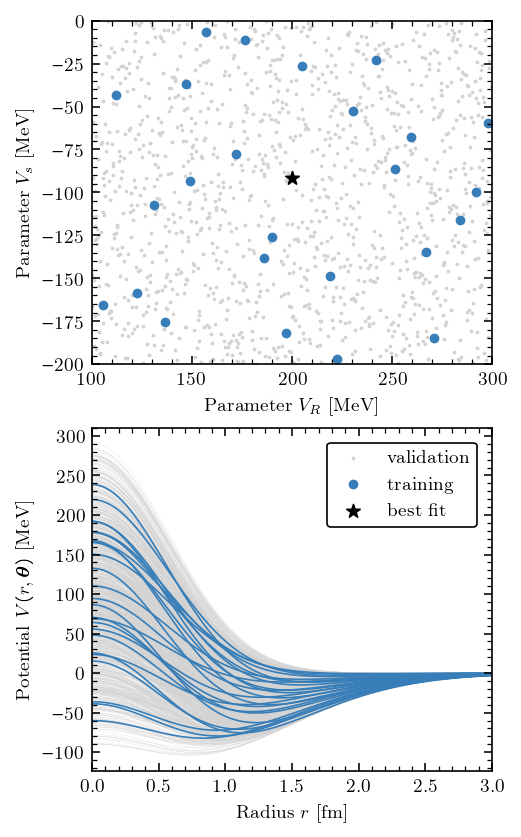

In [4]:
from constants import hbarc, cm
fig, axs = plt.subplots(2, 1, figsize=(8.6*cm,14*cm), constrained_layout=True)
np.random.seed(123)

for index, lbl in enumerate(("validation", "training")):
    param_samples_all = param_samples[lbl]
    param_samples_plot = np.array([[sample[lec_lbl] for lec_lbl in ("V0", "V1")] for sample in param_samples_all])
    color = ("lightgray", colors[1])[index]
    size = [1, 15][index]
    axs[0].scatter(param_samples_plot[:,0], param_samples_plot[:,1], color=color, s=size, label=("validation", "training")[index])
    
    grid_plot = np.linspace(0, 4, 200)
    size = [1.2, 8][index]
    for lec_sample in param_samples_all:
        vr = hbarc * potential.eval(r=grid_plot, lecs=lec_sample)
        axs[1].plot(grid_plot, vr, color=color, lw=size/10)

axs[0].scatter(potential.lecBaseValues["V0"], 
               potential.lecBaseValues["V1"], color="k", s=45, marker="*", label="best fit")
axs[0].set_xlabel("Parameter $V_R$ [MeV]")
axs[0].set_ylabel("Parameter $V_s$ [MeV]")
axs[0].set_xlim(*VR_range)
axs[0].set_ylim(*Vs_range)
axs[1].set_xlim(0,3)
axs[1].set_xlabel("Radius $r$ [fm]")
axs[1].set_ylabel(r"Potential $V(r, \boldsymbol{\theta})$ [MeV]")
axs[1].legend(*axs[0].get_legend_handles_labels())
fig.savefig(f"{output_dir}/minnesota_parameter_space.png", dpi=200)

## Comparison with the Runge-Kutta adaptive FOM solver

Next, we study the emulator's accuracy at the wavefunction level. First, we need to specify the scattering experiment, including the partial-wave channel and energy:

In [5]:
l = 0
potentialArgs = {"label": "minnesota", "kwargs": {"potId": 213}}
channel = Channel(S=0, L=l, LL=l, J=l, channel=0)
potential = Potential(channel, **potentialArgs)
trainingLecList, testingLecList = Potential.getSampleLecs(potentialArgs["label"])

E_MeV = 50 # MeV
scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)

# generate training data
rmatch = 12
rmin = 1e-12 
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 

Next, we set up the RSE solvers and solve the RSE using the matrix Numerov method and RK45. Note that below one can specify whether to solve the homogeneous or inhomogeneous RSE. We choose the later.

phase shifts (Numerov vs. RK45): 16.827887973099042 16.827887937559247 3.5539795106842575e-08


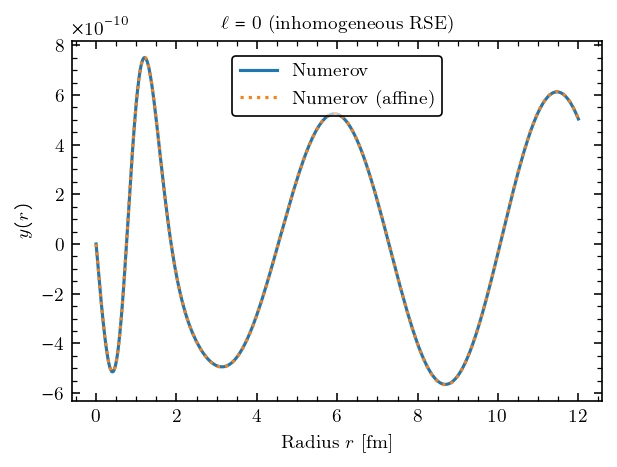

In [6]:
from RseSolver import RseSolver
solver = RseSolver(scattExp, grid, inhomogeneous=True)  # decide here whether to solve the homogeneous or inhomogeneous RSE
kwargs = dict(lecList=testingLecList, asympParam="K", matching=True)
scattSols_numerov_affine = solver.solve(method="Numerov_affine", **kwargs)
scattSols_numerov = solver.solve(method="Numerov", **kwargs)
scattSols_rk45 = solver.solve(method="RK45", **kwargs)

pr = grid.points * scattExp.p
plt.figure(figsize=(4,3))
plt.plot(grid.points, np.real(scattSols_numerov[0].u-scattSols_rk45[0].u), label="Numerov")
plt.plot(grid.points, np.real(scattSols_numerov_affine[0].u-scattSols_rk45[0].u), 
         ls=":", label="Numerov (affine)")
# plt.plot(grid.points, greedy_grom.simulate([[1,200, -91.85]])[:,0] - scattSols_rk45[0].u, label="Numerov")
plt.xlabel("Radius $r$ [fm]")
plt.ylabel("$y(r)$")
# plt.xlim(-0.1,0.1)
rse_lbl = "inhomogeneous" if solver.inhomogeneous else "homogeneous"
plt.title(f"$\\ell = {l}$ ({rse_lbl} RSE)")
plt.legend()

a = scattSols_numerov[0].Lmatrix.phaseShift
b = scattSols_rk45[0].Lmatrix.phaseShift
print("phase shifts (Numerov vs. RK45):", a, b, np.abs(a-b))

As one can see, the matrix Numerov method (FOM solver) reproduces well (see the overall small magnitude of the error) the wave function obtained with the adaptive RK45 method (also an FOM).

## Illustration of the greedy algorithm in 1D (Figure 6)

Our main class for emulation is `MatrixNumerovROM`. It supports various training and emulation approaches, including the POD and greedy algorithm. Let's get to know it.

Before we look more into the greedy algorithm, let's investigate the POD approach. Below we set up a G-ROM and an LSPG-ROM, both trained using the POD.

In [7]:
from NumerovEmulator import MatrixNumerovROM
inhomogeneous = True
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": Vs_range}, 
            num_snapshots_init=20, 
            num_snapshots_max=200, 
            approach="pod", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=3, 
            mode="linear",
            inhomogeneous=inhomogeneous,
            seed=10203
            )
pod_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
pod_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)
outp = pod_lspg.emulate([[1, 200, -91.85]], mode="lspg", which="all_y0y1")
# outp = pod_grom.emulate([[1, 200, -91.85]], which="all")
# outp = pod_lspg.simulate([[1, 200, -91.85]], which="all")

using 6 out of 20 POD modes in total: compression rate is 70.0 %
POD[ Y ]: compression rate is 23.8 %; dim: (998, 16)
using 6 out of 20 POD modes in total: compression rate is 70.0 %
POD[ Y ]: compression rate is 23.8 %; dim: (998, 16)
emulating 'all_y0y1' using 'lspg'


Note that the output tells us the number of dominant POD modes used and the corresponding compression rate. The POD's threshold is set by `pod_rcond`. The number of snapshots is set by `num_snapshots_init`.

It is important to note that the FOM solvers do not normalize the wave function such that the asymptotic limit parametrization (via the K matrix) is obtained. This matching has to be done in a postprocessing step.

We can use for this task the class `ScatteringSolution`:

In [8]:
from RseSolver import ScatteringSolution
scattSol = ScatteringSolution(scattExp=scattExp, 
                            vr=None,
                                grid=grid, 
                                f=outp[:,0], 
                                fprime=None,
                                f_lbl=("chi" if inhomogeneous else "u"),
                                anc=1./scattExp.p,
                                Llbl="K",
                                matching=True)
print("phase shift (deg):", scattSol.phaseShift)
print("K matrix:", scattSol.Lmatrix.valueAs("K"))


phase shift (deg): 16.82788805587012
K matrix: 0.30244898519349195


Likewise, we can let the emulator do the work, as described in the manuscript. Below is the output for the phase shift:

In [9]:
pod_lspg.emulate([[1, 200, -91.85]], which="delta")

emulating 'delta' using 'lspg'


array([16.82788806])

In [10]:
sim_delta = pod_grom.simulate([[1, 200, -91.85]], which="delta")
emu_delta = pod_grom.emulate([[1, 200, -91.85]], which="delta")
print("simulated phase shift (deg):", sim_delta)
print("emulated phase shift (deg):", emu_delta)
print("difference:", sim_delta - emu_delta)

emulating 'delta' using 'grom'
simulated phase shift (deg): [16.82788797]
emulated phase shift (deg): [16.82788789]
difference: [8.16586514e-08]


As we can see, the emulator (here, the G-ROM) reproduces the scattering phase shift very well.

We can also look at the difference between the emulator's output for the wave function (as described in the manuscript) and the post-processed step up:

emulating 'u' using 'lspg'


Text(0.5, 0, '$r$')

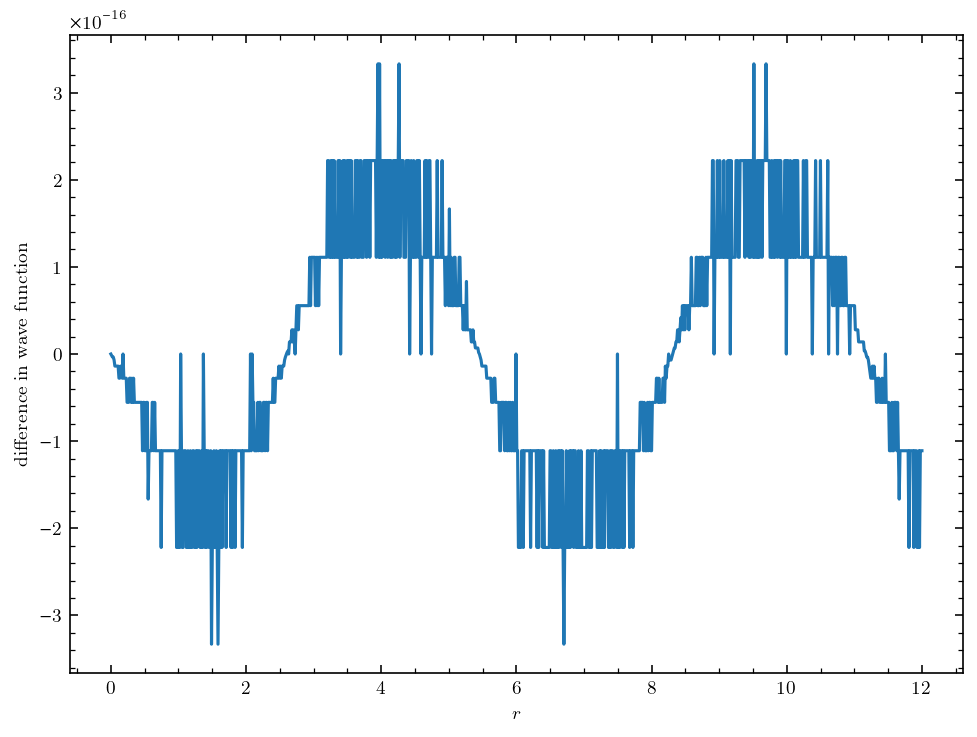

In [11]:
plt.plot(grid.points, pod_lspg.emulate([[1, 200, -91.85]], which="u")[:,0] - scattSol.u)
plt.ylabel("difference in wave function")
plt.xlabel("$r$")

## Demonstration of the greedy algorithm in 1D

Next, we demonstrate the the greedy iteration using the potential's dependence on the parameter $V_s$ (which is negative). 

We do this for both the G-ROM and the LSPG-ROM. 

### Training and exploration

First, we need to train the emulator. This can be relatively slow because we also compute the theoretical error bounds using the SVD of the FOM matrix. In practice, one would not do that in favor of the SCM, as discussed in the manuscript.

In [12]:
from NumerovEmulator import MatrixNumerovROM
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            free_lecs={"V1": Vs_range}, 
            num_snapshots_init=2, 
            num_snapshots_max=200, 
            approach="greedy", 
            pod_rcond=1e-10, 
            init_snapshot_lecs=None,
            greedy_max_iter=4, 
            mode="linear",
            # inhomogeneous=False,
            seed=734249391 # 10203
            )
greedy_grom = MatrixNumerovROM(greedy_training_mode="grom", **args)
greedy_lspg = MatrixNumerovROM(greedy_training_mode="lspg", **args)

POD[ Y ]: compression rate is 33.3 %; dim: (998, 6)
snapshot idx already included in basis: {155, 70}
now greedily improving the snapshot basis:
	iteration #1 of max 4:
	available candidate snapshot idx to be added: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Let's see how the G-ROM does at the potential's best-fit values:

In [13]:
lecs_best_fit = [[1, 200, -91.85]]
print(greedy_grom.simulate(lecs_best_fit, which="delta"))
print(greedy_grom.emulate(lecs_best_fit, which="delta"))
greedy_grom.simulate(lecs_best_fit, which="delta") - greedy_grom.emulate(lecs_best_fit, which="delta")

[16.82788797]
emulating 'delta' using 'grom'
[16.82786419]
emulating 'delta' using 'grom'


array([2.37853623e-05])

Let's see how the LSPG-ROM does at the potential's best-fit values:

In [14]:
print(greedy_lspg.simulate(lecs_best_fit, which="delta"))
print(greedy_lspg.emulate(lecs_best_fit, which="delta"))
greedy_lspg.simulate(lecs_best_fit, which="delta") - greedy_lspg.emulate(lecs_best_fit, which="delta")

[16.82788797]
emulating 'delta' using 'lspg'
[16.82786392]
emulating 'delta' using 'lspg'


array([2.40484169e-05])

### Greedy algorithm in action

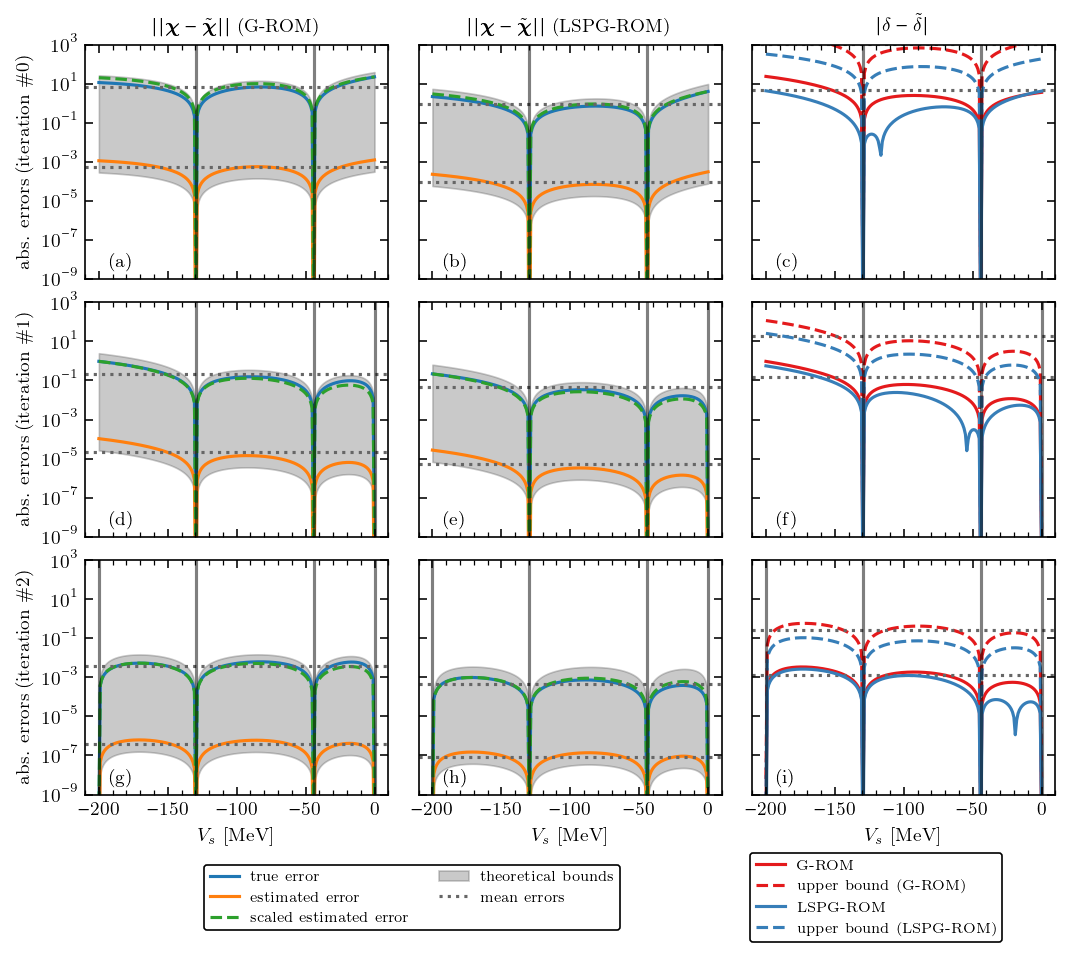

In [15]:
from constants import cm
mpl.rcParams['figure.constrained_layout.use'] = False
num_iter = len(greedy_lspg.greedy_logging) - 1
V0_arr = greedy_lspg.lec_all_samples[:,2]
fig, axs = plt.subplots(num_iter, 3, sharex=True, sharey=True,
                        figsize=(18*cm,16*cm), layout=None)
axs = np.atleast_1d(axs)
plt.subplots_adjust(left=0.07, right=0.99, 
                    top=0.96, bottom=0.16, 
                    wspace=0.1, hspace=0.1)
for ax in axs[-1,:]:
    ax.set_xlabel("$V_s$ [MeV]")
for iax, ax in enumerate(axs[:,0]):
    ax.set_ylabel(f"abs. errors (iteration \\#{iax})")
for ax, title in zip(axs[0,:], ("$||\\boldsymbol{\\chi} - \\tilde{\\boldsymbol{\\chi}}||$ (G-ROM)", 
                                "$||\\boldsymbol{\\chi} - \\tilde{\\boldsymbol{\\chi}}||$ (LSPG-ROM)", 
                                r"$|\delta - \tilde{\delta}|$")):
    ax.set_title(title)

axs[0,0].set_ylim(1e-9, 1e3)

for niter in range(num_iter):
    for irom_lbl, rom_lbl in enumerate(("g-rom", "lspg-rom")): # "lspg")):
        rom = greedy_grom if rom_lbl == "g-rom" else greedy_lspg
        ax = axs[niter, irom_lbl]
        [snapshot_idxs, fom_sol, emulated_sol, 
        romErrors, realErrors, estErrBounds,
        coercivity_constant, 
        delta_rom, delta_fom, error_est_delta] = rom.greedy_logging[niter]
        ax.semilogy(V0_arr, realErrors, label=f"true error")
        ax.semilogy(V0_arr, romErrors, ls="-", label=f"estimated error")
        ax.semilogy(V0_arr, coercivity_constant*romErrors, 
                    ls="--", label=f"scaled estimated error")
        
        ax.fill_between(V0_arr, estErrBounds[:,0], estErrBounds[:,1], 
                        alpha=0.3, color='0.3',
                        zorder=0, label="theoretical bounds")
        
        for ierr, err in enumerate((romErrors, realErrors)):
            label = "mean errors" if irom_lbl==0 and ierr == 0 else ""
            ax.axhline(np.mean(err), ls=":", c='0.4', label=label)

        for idx in snapshot_idxs:
            ax.axvline(V0_arr[idx], c="k", alpha=0.5)

        ax = axs[niter, 2]
        delta_err_exact = np.abs(delta_fom-delta_rom)
        color = colors[irom_lbl]
        ax.semilogy(V0_arr, delta_err_exact, color=color, label=rom_lbl.upper())
        if rom_lbl == "g-rom":
            ax.axhline(np.mean(delta_err_exact), ls=":", c='0.4', label=label)

        ax.semilogy(V0_arr, error_est_delta, color=color, ls="--", label=f"upper bound ({rom_lbl.upper()})")
        if rom_lbl == "g-rom":
            ax.axhline(np.mean(error_est_delta), ls=":", c='0.4', label=label)

    for idx in snapshot_idxs:
        axs[niter, 2].axvline(V0_arr[idx], c="k", alpha=0.5)
    
axs[-1,0].legend(bbox_to_anchor =(0.38, 0.05), loc='center', ncol=2, 
                    bbox_transform=fig.transFigure, fontsize=7)
for iax, ax in enumerate(axs.flatten()):
    ax.text(0.08, 0.05, f"({alphabet[iax]})", transform = ax.transAxes)
# axs[0,0].legend(loc='lower left', ncol=4, bbox_to_anchor =(1.5,2.65))
axs[-1,-1].legend(bbox_to_anchor =(0.82, 0.05), loc='center', ncol=1, 
                    bbox_transform=fig.transFigure, fontsize=7)
fig.savefig(f"greedy_MN_potential_1S0.pdf")

## Simple start: POD emulator

Here, we study the POD emulator as a function of the included dominant POD modes. Just because it might be interesting.

In [16]:
from NumerovEmulator import MatrixNumerovROM
inhomogeneous = True
grid = Grid(rmin, rmatch, numIntervals=1, 
            numPointsPerInterval=1000,
            type="linear", test=False) 
args = dict(scattExp=scattExp, 
            grid=grid, 
            # free_lecs={"V1": Vs_range}, 
            num_snapshots_init=20, 
            num_snapshots_max=200,  # irrelevant for POD
            approach="pod", 
            pod_rcond=None, 
            init_snapshot_lecs=param_samples["training"],
            greedy_max_iter=3, 
            mode="random",
            inhomogeneous=inhomogeneous,
            verbose=False,
            seed=10203
            )

lecs_list = potential.lec_array_from_dict(param_samples["validation"])
outp_sim = scattExp.p / pod_grom.simulate(lecs_list, which="K")
res = []
for pod_num_modes in range(2, 9):
    pod_grom = MatrixNumerovROM(pod_num_modes=pod_num_modes, **args)
    outp_emu = scattExp.p / pod_grom.emulate(lecs_list, mode="grom", which="K")
    rel_err = np.abs((outp_sim-outp_emu)/outp_sim)
    res.append([pod_num_modes, 
                np.mean(rel_err), np.min(rel_err), np.max(rel_err)])
res = np.array(res)

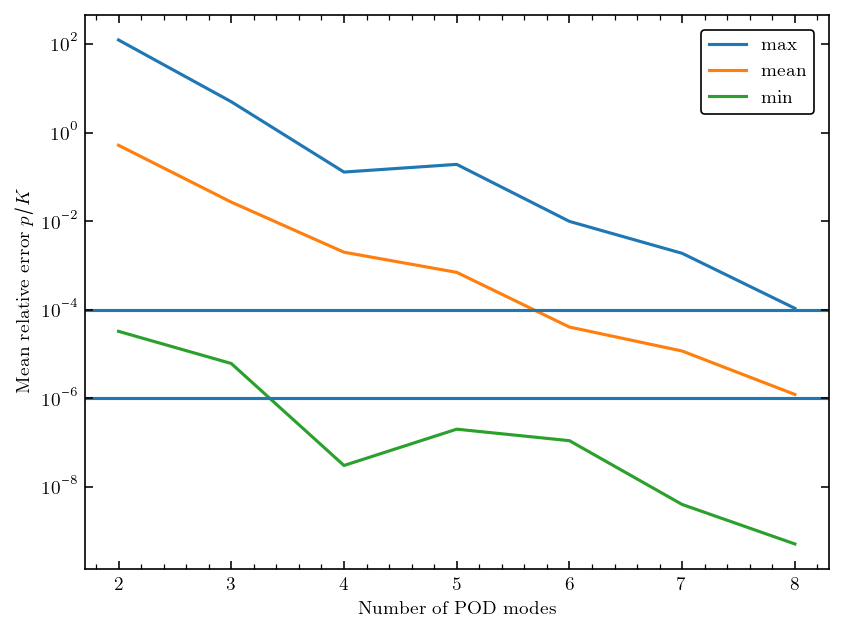

In [17]:
plt.semilogy(res[:,0], res[:,3], label="max")
plt.semilogy(res[:,0], res[:,1], label="mean")
plt.semilogy(res[:,0], res[:,2], label="min")
plt.axhline(1e-6)
plt.axhline(1e-4)
plt.xlabel("Number of POD modes")
plt.ylabel("Mean relative error $p / K$")
plt.legend()

In [18]:
lecs_list = potential.lec_array_from_dict(param_samples["validation"])
outp1 = pod_grom.emulate(lecs_list, which="delta")
outp2 = pod_grom.simulate(lecs_list, which="delta")
np.mean(np.abs((outp1-outp2)/outp1))

9.211952261385752e-07

## Convergence analysis

Figures 7 and 8 in the manuscript. The evaluation may take a while (~1h).

In [19]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd

E_MeV_arr = (50, 100)
emulator_type = "grom"

df_E_MeV_arr = []
df = pd.DataFrame()
for E_MeV in E_MeV_arr:
    print(f"working on E = {E_MeV} MeV")
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, emulator_type=emulator_type)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df["emulator_type"] = emulator_type
    df_E_MeV_arr.append(df)
    print("")

working on E = 50 MeV
scanning 2300 (out of 2300) for best/worst initial emulator basis
worst idxs: [ 6 15 20]
best idxs: [ 8  9 23]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (200 samples)
	running with 4 snapshots (200 samples)
	running with 5 snapshots (200 samples)
	running with 6 snapshots (200 samples)
	running with 7 snapshots (200 samples)
	running with 8 snapshots (200 samples)

working on E = 100 MeV
scanning 2300 (out of 2300) for best/worst initial emulator basis
worst idxs: [ 3  5 20]
best idxs: [11 12 23]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	runni

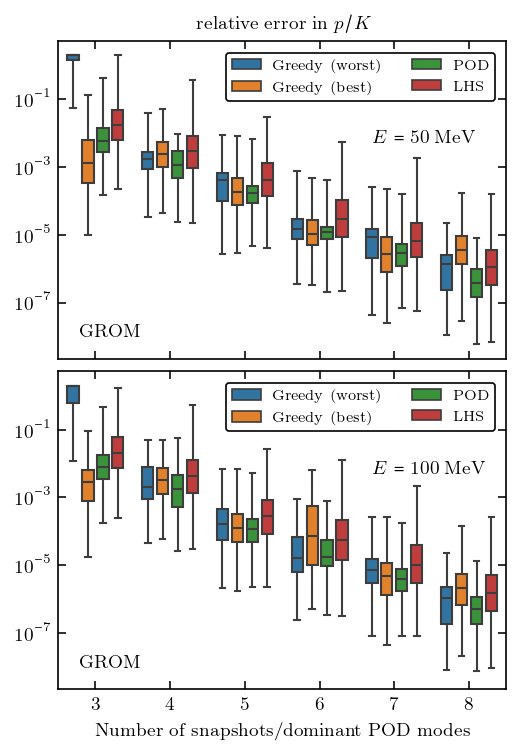

In [ ]:
convergenceFig(df_E_MeV_arr, E_MeV_arr, emulator_type)
df.to_csv("df_conv_mn_grom.csv.gz", index=False)

In [21]:
from figures import convergenceAnalysis, convergenceFig
import seaborn as sns
import pandas as pd

E_MeV_arr = (50, 100)
emulator_type = "lspg"

df_E_MeV_arr = []
df = pd.DataFrame()
for E_MeV in E_MeV_arr:
    print(f"working on E = {E_MeV} MeV")
    res = convergenceAnalysis(param_samples, E_MeV=E_MeV, emulator_type=emulator_type)
    df = res.track_greedy_emulators(df_out=df)
    df = res.track_POD_emulator(df_out=df)
    df = res.track_LHS_emulator(df_out=df)
    df["emulator_type"] = emulator_type
    df_E_MeV_arr.append(df)
    print("")

working on E = 50 MeV
scanning 2300 (out of 2300) for best/worst initial emulator basis
worst idxs: [ 1  4 24]
best idxs: [ 2  9 21]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking POD emulator
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running with 6 snapshots
	running with 7 snapshots
	running with 8 snapshots
tracking LHS emulator
	running with 3 snapshots (200 samples)
	running with 4 snapshots (200 samples)
	running with 5 snapshots (200 samples)
	running with 6 snapshots (200 samples)
	running with 7 snapshots (200 samples)
	running with 8 snapshots (200 samples)

working on E = 100 MeV
scanning 2300 (out of 2300) for best/worst initial emulator basis
worst idxs: [1 6 7]
best idxs: [ 7  9 15]
tracking greedy emulators
	running with 3 snapshots
	running with 4 snapshots
	running with 5 snapshots
	running 

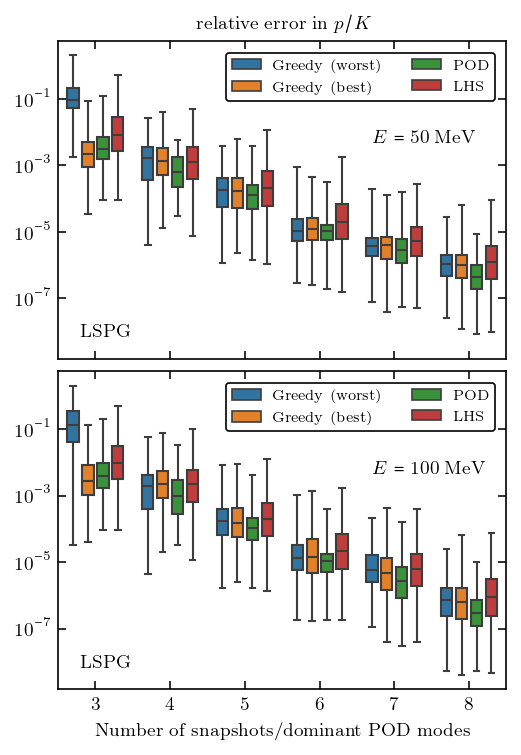

In [ ]:
convergenceFig(df_E_MeV_arr, E_MeV_arr, emulator_type)
df.to_csv("df_conv_mn_lspg.csv.gz", index=False)

In [16]:
df

,Unnamed: 0,approach,num_snapshots,error,emulator_type
0,0,Greedy (worst),3,1.161779e+00,grom
1,1,Greedy (worst),3,2.000000e+00,grom
2,2,Greedy (worst),3,1.394859e+00,grom
3,3,Greedy (worst),3,2.000000e+00,grom
4,4,Greedy (worst),3,3.512399e-01,grom
...,...,...,...,...,...
3044995,1245,LHS,8,6.954171e-07,grom
3044996,1246,LHS,8,2.399095e-06,grom
3044997,1247,LHS,8,1.204359e-05,grom
3044998,1248,LHS,8,1.100796e-05,grom


/Users/drischler/GitHub/greedy_emulator/env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


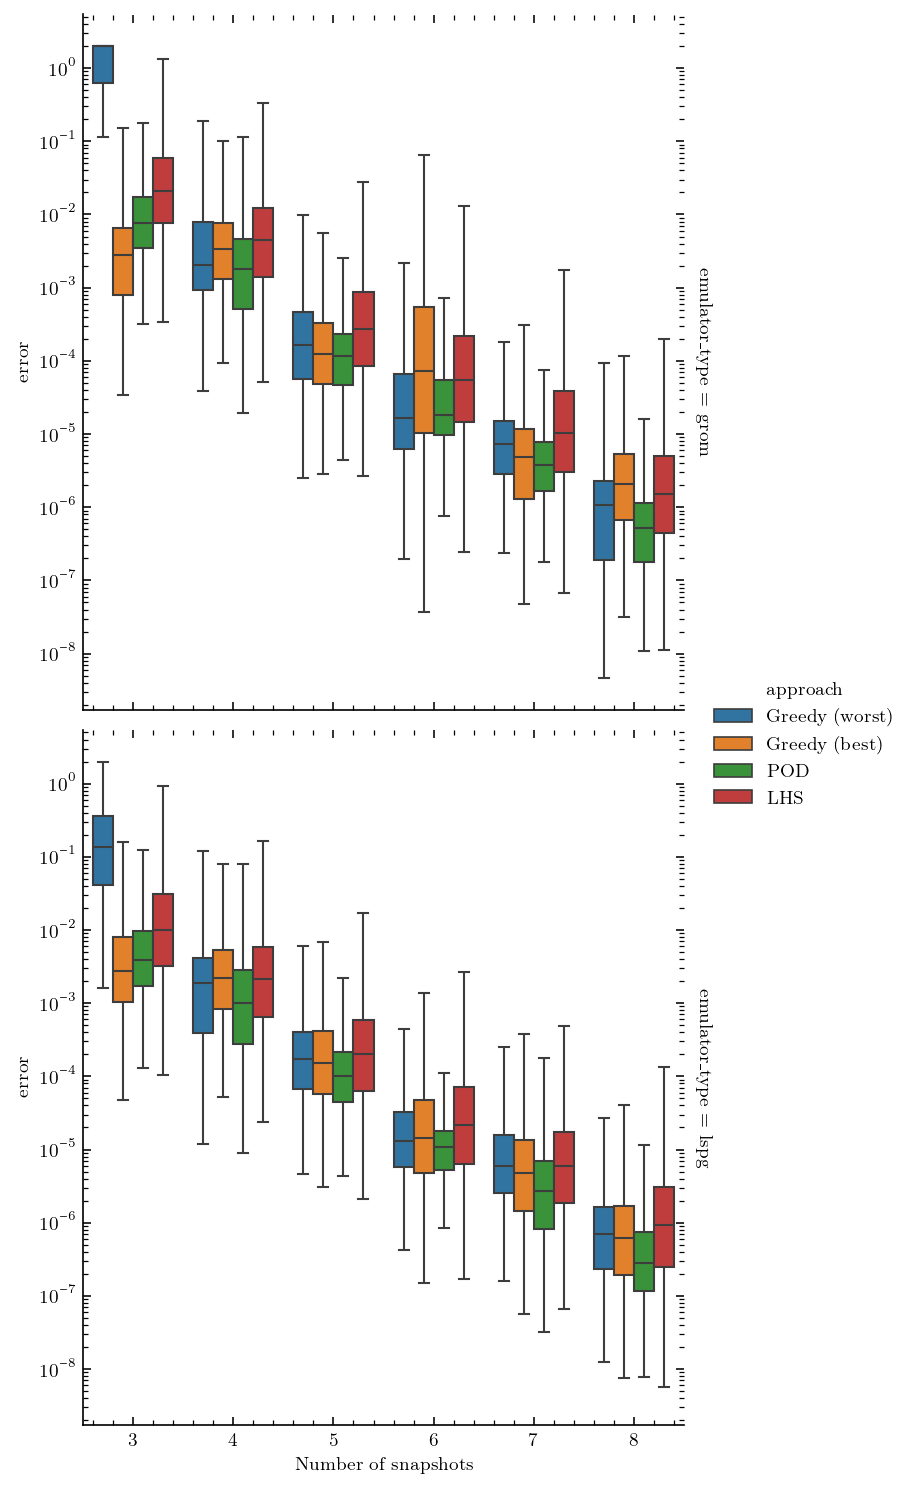

In [18]:
import pandas as pd
import seaborn as sns
df1 = pd.read_csv("df_conv_mn_grom.csv.gz")
df2 = pd.read_csv("df_conv_mn_lspg.csv.gz")
df = pd.concat((df1, df2))
g = sns.catplot(
    data=df,
    x="num_snapshots", 
    y="error", 
    hue="approach", 
    row="emulator_type",
    kind="box", 
    # orient="h",
    # sharex=False, 
    margin_titles=True,
    # height=1.5, 
    # aspect=1,
    log_scale=True,
    showfliers = False
)

g.set(xlabel="Number of snapshots", ylabel="error")

# g.set_titles(row_template="{row_name} class")
# for ax in g.axes.flat:
    # ax.xaxis.set_major_formatter('${x:.0f}')